# AVANCE II  PROYECTO INTEGRADOR

### Grupo: 001, Lunes-Miércoles-Viernes/6:00pm-7:00pm
### Equipo 7
    - Josias de la Cruz Cruz               1750176
    - Carlos Abraham Murillo Valdés        1488911
    - Luisa Rubí Villegas Rincón           1752574

## Base de datos: Novel Corona Virus 2019 Dataset

### Descripción de la base de datos
La base de datos con la que se va a estar trabajando contiene información general a nivel mundial acerca del virus COVID-19.
Trabajaremos en esta base de datos con el objetivo de determinar distintas probabilidades que puede generar este virus.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import datetime
from datetime import date, timedelta
from sklearn.cluster import KMeans
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


### Descripción de las columnas.

    ● Sno - Número de serie
    ● Date - Fecha y hora de la observación en MM / DD / AAAA HH: MM: SS.
    ● Province / State - Provincia o estado de la observación (podría estar vacío cuando falta).
    ● Country - País de observación.
    ● Last Update - Hora en UTC en la que se actualiza la fila para la provincia o país en cuestión.
    ● Confirmed - Número acumulado de casos confirmados hasta esa fecha
    ● Deaths - Número acumulado de muertes hasta esa fecha.
    ● Recovered - Número acumulado de casos recuperados hasta esa fecha. 

## Justificación de los datos

La principal característica que nos llamó la atención de esta base de datos fue que utiliza datos discretos, lo cual nos fue fácil de entender su significado. Estos datos representan las frecuencias o las incidencias de estado en la que una persona contagiada de coronavirus puede estar. También podemos observar su ubicación geográfica y la hora de registro.

Los principales beneficio de trabajar con datos discretos, es que, nos es sencillo visualizar las frecuencias de los estados posibles de una persona de covid 19, considerándola como nuestra unidad de estudio. Una persona es = 1 no es posible que una persona valga ½. Bajo esa premisa trabajaremos en este proyecto.


### Preguntas de interés

Nuestras preguntas concretas son las que se mencionan a continuación, pero a lo largo del proyecto existe la posibilidad de poder agregar más.

##### ¿Cual es la probabilidad de contagio, muerte y recuperación de cierta área geográfica?

##### ¿Cuáles son las probaibilidades de que presenten ciertos conjuntos de estados (Confirmed, Deaths y Recovered) a la vez en determinada area geografica?.

## Limpieza de datos

En nuestro caso las base de datos que vamos a utilizar en su gran mayoria no tiene muchas variables innecesarios por lo que la limpieza sería mínima, esto es debido a que derivan de una base de datos general, es decir, a apartir de la base de datos general se clasificó la información que se tiene sobre los casos de covid-19 a nivel mundial en el estado que pueden presentar las personas, esto es, una base de datos para el estado de caso confirmado, caso fallecido y caso recuperado. A partir de estas varibles podremos realizar los procedimientos que se realizarán más adelante para resolver nuestras preguntas de interés.

En las suguientes líneas de código se realizará la limpieza de las variables innecesarias de las bases de datos que contiene los estados que presentan las personas, para posteriormente crear clases de los casos acumulados del estado (Confirmed, Deaths, Recovered) que puedan presentar las personas ante el virus. 

#### Nota:
El mismo procedimiento de limpieza que se realizará con la base de datos de los casos confirmados se hará de igual manera para la base de datos de casos fallecidos y la de casos recuperados.

### Caso confirmados

In [2]:
covid_confirmed = pd.read_csv("time_series_covid_19_confirmed.csv") 
covid_confirmed.shape # Nos muestra el tamaño de nuestra base de datos

(264, 95)

In [3]:
covid_confirmed.head()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,04/12/2020,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,607,665,714,784,840,906,933,996,1026,1092
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,446,467,475,494,518,539,548,562,584,609
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,638,646,659,673,673,696,704,713,717,717
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,24,24,24,24


En esta parte cargamos la base datos original de casos confirmados acumulativos de covid-19 por fecha a nivel mundial (01/22/2020 - 04/21/2020) que cuenta con 264 filas y 95 columnas (en este caso solo mostramos 5 filas con sus columnas) para visualizar las varibles que no vamos a utilizar, esto para realizar la eliminación de dichas varibles que nos permitirán tener un mejor orden de nuestros datos.

In [4]:
new_covid_confirmed = covid_confirmed.drop(['Lat', 'Long'], axis=1)

Se eliminaron las variables de 'Lat' y 'Long' que representan la longitud y latidud de cada estado del país ya que no son relevantes para nuestro proyecto.

Ahora ya que corregimos la base de datos de las variables innecesarios para el proyecto veremos a qué tipo de dato corresponden y si cuenta con valores nulos.

In [5]:
new_covid_confirmed.dtypes # Muestra el tipo de dato

State      object
Country    object
1/22/20     int64
1/23/20     int64
1/24/20     int64
            ...  
4/17/20     int64
4/18/20     int64
4/19/20     int64
4/20/20     int64
4/21/20     int64
Length: 93, dtype: object

In [6]:
new_covid_confirmed.isnull().any() # Muestra si contiene valores nulos

State       True
Country    False
1/22/20    False
1/23/20    False
1/24/20    False
           ...  
4/17/20    False
4/18/20    False
4/19/20    False
4/20/20    False
4/21/20    False
Length: 93, dtype: bool

Resultado True: indica que si contiene valores nulos, False: indica que no contiene valores nulos.

Con la información que se nos ha mostrados respecto a los tipos de datos y datos nulos podemos a empezar a trabajar con nuestra nueva base de datos ya que la información que se nos mostró es la adecuada para seguir con el procedimineto siguiente.

### Nota: En las siguienetes dos bases de datos se realizará el mismo procedimiento que en la base de datos de confirmados.

### Caso fallecidos

In [7]:
covid_deaths = pd.read_csv("time_series_covid_19_deaths.csv") 
covid_deaths.shape # Nos muestra el tamaño de nuestra base de datos

(264, 95)

In [8]:
covid_deaths.head()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,04/12/2020,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,18,21,23,25,30,30,30,33,36,36
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,23,23,24,25,26,26,26,26,26,26
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,293,313,326,336,348,364,367,375,384,392
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,29,29,31,33,33,35,35,36,37,37
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


Base de datos con casos de fallecidos acumulativos de covid 19 por fecha a nivel mundial (01/22/2020 - 04/21/2020).

In [9]:
new_covid_deaths = covid_deaths.drop(['Lat', 'Long'], axis=1)

Ahora ya que corregimos la base de datos de las variables innecesarios para el proyecto veremos a qué tipo de dato corresponden y si cuenta con valores nulos.

In [10]:
new_covid_deaths.dtypes # Muestra el tipo de dato

State      object
Country    object
1/22/20     int64
1/23/20     int64
1/24/20     int64
            ...  
4/17/20     int64
4/18/20     int64
4/19/20     int64
4/20/20     int64
4/21/20     int64
Length: 93, dtype: object

In [11]:
new_covid_deaths.isnull().any() # Muestra si contiene valores nulos

State       True
Country    False
1/22/20    False
1/23/20    False
1/24/20    False
           ...  
4/17/20    False
4/18/20    False
4/19/20    False
4/20/20    False
4/21/20    False
Length: 93, dtype: bool

### Caso recuperados

In [12]:
covid_recovered = pd.read_csv("time_series_covid_19_recovered.csv") 
covid_recovered.shape # Nos muestra el tamaño de nuestra base de datos

(250, 95)

In [13]:
covid_recovered.head()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,04/12/2020,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,32,32,40,43,54,99,112,131,135,150
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,217,232,248,251,277,283,302,314,327,345
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,591,601,691,708,783,846,894,1047,1099,1152
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,128,128,128,169,169,191,205,235,248,282
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,4,4,5,5,5,5,6,6,6,6


Base de datos con casos recuperados acumulativos de covid 19 por fecha a nivel mundial (01/22/2020 - 04/21/2020).

In [14]:
new_covid_recovered = covid_recovered.drop(['Lat', 'Long'], axis=1)

In [15]:
new_covid_recovered.dtypes # Muestra el tipo de dato

State      object
Country    object
1/22/20     int64
1/23/20     int64
1/24/20     int64
            ...  
4/17/20     int64
4/18/20     int64
4/19/20     int64
4/20/20     int64
4/21/20     int64
Length: 93, dtype: object

In [16]:
new_covid_recovered.isnull().any() # Muestra si contiene valores nulos

State       True
Country    False
1/22/20    False
1/23/20    False
1/24/20    False
           ...  
4/17/20    False
4/18/20    False
4/19/20    False
4/20/20    False
4/21/20    False
Length: 93, dtype: bool

### Lo siguiente será crear las nuevas bases de datos ya corregidos y limpios.

In [17]:
new_covid_confirmed.to_csv('covid_confirmed.csv', index=False)
new_covid_confirmed = pd.read_csv('covid_confirmed.csv')

In [18]:
new_covid_deaths.to_csv('covid_deaths.csv', index=False)
new_covid_deaths = pd.read_csv('covid_deaths.csv')

In [19]:
new_covid_recovered.to_csv('covid_recovered.csv', index=False)
new_covid_recovered = pd.read_csv('covid_recovered.csv')

In [20]:
new_covid_confirmed.head()

,State,Country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,04/12/2020,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,607,665,714,784,840,906,933,996,1026,1092
1,NaN,Albania,0,0,0,0,0,0,0,0,...,446,467,475,494,518,539,548,562,584,609
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,638,646,659,673,673,696,704,713,717,717
4,NaN,Angola,0,0,0,0,0,0,0,0,...,19,19,19,19,19,19,24,24,24,24


In [21]:
new_covid_deaths.head()

,State,Country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,04/12/2020,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,18,21,23,25,30,30,30,33,36,36
1,NaN,Albania,0,0,0,0,0,0,0,0,...,23,23,24,25,26,26,26,26,26,26
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,293,313,326,336,348,364,367,375,384,392
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,29,29,31,33,33,35,35,36,37,37
4,NaN,Angola,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [22]:
new_covid_recovered.head()

,State,Country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,04/12/2020,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,32,32,40,43,54,99,112,131,135,150
1,NaN,Albania,0,0,0,0,0,0,0,0,...,217,232,248,251,277,283,302,314,327,345
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,591,601,691,708,783,846,894,1047,1099,1152
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,128,128,128,169,169,191,205,235,248,282
4,NaN,Angola,0,0,0,0,0,0,0,0,...,4,4,5,5,5,5,6,6,6,6


Creación de las funciones que utilizaremos.

In [23]:
# Esta función calcula el total de datos acumulados que puede presentar un país, es decir, suma el total
# de casos de confirmados, fallecidos y recuperados a la última fecha de registro de la base de datos.
#
# @param countryUniqueArray: Arreglo de los nombres de los países únicos
# @param countryArray: Arreglo de los nombres de los países que pueden repetirse
# @oaram array: Arreglo de la base de datos de casos confirmados

def covidState(countryUniqueArray, countryArray, array):
    countryList = [0 for i in range(len(countryUniqueArray))]
    for i in range(len(countryUniqueArray)):
        contador=0
        for j in range(len(countryArray)):
            if countryUniqueArray[i] == countryArray[j]:
                contador = contador + (array.loc[j, '4/21/20'])
                countryList[i]=contador
    return countryList

In [24]:
# Esta función calcula el total de datos acumulados por fechas, es decir, suma el total
# de casos de confirmados, fallecidos y recuperados por día y se almacena en un arreglo, desde 
# la fecha inicial hasta la última fecha de registro de la base de datos.
#
# @param countryUniqueArray: Arreglo de los nombres de los países únicos
# @param date: Arreglo de las fechas, de fecha inicial hasta fecha final

def totalCasesCovid(countryUniqueArray, date):
    i=2
    totalDayConfirmed = [0 for i in range(len(date))]
    for i in range(len(countryUniqueArray.columns)):
        totalDayConfirmed[i-2] = countryUniqueArray[date[i-2]].sum()
    return totalDayConfirmed    

En las siguientes 3 lineas de código se crean 3 arreglos para cada caso (confirmado, fallecido, recuperado), con los nombres de los paises únicos que contiene su respectivo dataframe.

In [25]:
countryUniqueArrayConfirmed = new_covid_confirmed.Country.unique()
countryUniqueArrayDeaths = new_covid_deaths.Country.unique()
countryUniqueArrayRecovered = new_covid_recovered.Country.unique()

En las siguientes 3 lineas de código se crean 3 arreglos para cada caso (confirmado, fallecido, recuperado), con los nombres de los paises que se pueden repetir,esto en su respectivo dataframe de cada uno.

In [26]:
countryArrayConfirmed = np.array(new_covid_confirmed["Country"])
countryArrayDeaths = np.array(new_covid_deaths["Country"])
countryArrayRecovered = np.array(new_covid_recovered["Country"])

Ahora, una vez creado los arreglos anteriores procedemos a crear 3 arreglos utilizando la función covidState() para obtener los datos acumulados totales de cada país.

In [27]:
countryListConfirmed = covidState(countryUniqueArrayConfirmed, countryArrayConfirmed, new_covid_confirmed)
countryListDeaths = covidState(countryUniqueArrayDeaths, countryArrayDeaths, new_covid_deaths)
countryListRecovered = covidState(countryUniqueArrayRecovered, countryArrayRecovered, new_covid_recovered)



Realizamos la creación de otros 3 arreglos, esta vez para obtener la fechas (desde la fecha de inicio, hasta a última fecha de nuestro dataframe) que posteriormente utlizaremos para crear nuestros dataframe propios. Como se puede observar en las siguientes lineas de código  después de haber creado el arreglo columnsConfirmed, columnsDeaths y columnsRecovered se eliminan los primeros dos elementos de nuestro arreglo, ya que contiene datos de otro tipo al que usaremos.

In [28]:
columnsConfirmed = np.array(new_covid_confirmed.columns) 
columnsConfirmed = np.delete(columnsConfirmed, 0)
columnsConfirmed = np.delete(columnsConfirmed, 0)

columnsDeaths = np.array(new_covid_deaths.columns) 
columnsDeaths = np.delete(columnsDeaths, 0)
columnsDeaths = np.delete(columnsDeaths, 0)

columnsRecovered = np.array(new_covid_recovered.columns) 
columnsRecovered = np.delete(columnsRecovered, 0)
columnsRecovered = np.delete(columnsRecovered, 0)

Llamamos a nuestra función totalCasesCovid() para sumar los casos totales (confirmados, fallecidos y recuperados) por fecha y igualamos a la varaible que le corresponde a cada una.

In [29]:
totalCovidConfirmed = totalCasesCovid(new_covid_confirmed, columnsConfirmed)
totalCovidDeaths = totalCasesCovid(new_covid_deaths, columnsDeaths)
totalCovidRecovered = totalCasesCovid(new_covid_recovered, columnsRecovered)

Creamos nuestros dataframe que utilizaremos más adelante para poder visulaizar nuestros datos de casos confirmados, fallecidos y recuperados mundiales en relación al tiempo/casos confirmados.

In [30]:
TotalConfirmed = {'Date': columnsConfirmed,
        'TotalConfirmed': totalCovidConfirmed,
        'TotalDeaths': totalCovidDeaths,
        'TotalRecovered': totalCovidRecovered
        }
dfDateCases = pd.DataFrame(TotalConfirmed, columns = ['Date', 'TotalConfirmed', 'TotalDeaths', 'TotalRecovered'])
dfDateCases

,Date,TotalConfirmed,TotalDeaths,TotalRecovered
0,1/22/20,555,17,28
1,1/23/20,654,18,30
2,1/24/20,941,26,36
3,1/25/20,1434,42,39
4,1/26/20,2118,56,52
...,...,...,...,...
86,4/17/20,2240190,153821,568343
87,4/18/20,2317758,159509,592319
88,4/19/20,2401378,165043,623903
89,4/20/20,2472258,169985,645738


Seguimos con la creación de 3 dataframe con los datos acumulados que obtuvimos a través de nuestras funciones para poder saber el total de cada caso en cada país.

In [31]:
dfConfirmed = pd.DataFrame({'Confirmed': countryListConfirmed}, index=countryUniqueArrayConfirmed)
dfDeaths = pd.DataFrame({'Deaths': countryListDeaths}, index=countryUniqueArrayDeaths)
dfRecovered = pd.DataFrame({'Recovered': countryListRecovered}, index=countryUniqueArrayRecovered)

In [32]:
dfConfirmed

,Confirmed
Afghanistan,1092
Albania,609
Algeria,2811
Andorra,717
Angola,24
...,...
Malawi,18
South Sudan,4
Western Sahara,6
Sao Tome and Principe,4


In [33]:
dfDeaths

,Deaths
Afghanistan,36
Albania,26
Algeria,392
Andorra,37
Angola,2
...,...
Malawi,2
South Sudan,0
Western Sahara,0
Sao Tome and Principe,0


In [34]:
dfRecovered

,Recovered
Afghanistan,150
Albania,345
Algeria,1152
Andorra,282
Angola,6
...,...
Malawi,3
South Sudan,0
Western Sahara,0
Sao Tome and Principe,0


En el siguiente codigo se crea un nuevo data-frame con el cual se represntara los estados de contagio acumulados totales de las perosnas en determinado pais.

In [35]:
bd = {'Country': countryUniqueArrayConfirmed,
      'Confirmed': countryListConfirmed,
      'Deaths': countryListDeaths,
      'Recovered': countryListRecovered,
        }

dfbd = pd.DataFrame(bd, columns = ['Country', 'Confirmed', 'Deaths', 'Recovered'])
dfbd

,Country,Confirmed,Deaths,Recovered
0,Afghanistan,1092,36,150
1,Albania,609,26,345
2,Algeria,2811,392,1152
3,Andorra,717,37,282
4,Angola,24,2,6
...,...,...,...,...
180,Malawi,18,2,3
181,South Sudan,4,0,0
182,Western Sahara,6,0,0
183,Sao Tome and Principe,4,0,0


Con la finalidad de realizar la una predicción de los casos confirmados, recuperados y fallecidos de la región de Estados Unidos; Crearemos un dataframe que contenga los casos acumulativos de casos confirmados, recuperados y fallecidos en Estados Unidos ordenados por fecha. 

In [69]:
USInformationConfirmed = new_covid_confirmed[new_covid_confirmed['Country']=='US']
USInformationDeaths = new_covid_deaths[new_covid_deaths['Country']=='US']
USInformationRecovered = new_covid_recovered[new_covid_recovered['Country']=='US']

In [70]:
USDateConfirmed = np.array(USInformationConfirmed.columns) 
USDateConfirmed = np.delete(USDateConfirmed, 0)
USDateConfirmed = np.delete(USDateConfirmed, 0)

USDateDeaths = np.array(USInformationDeaths.columns) 
USDateDeaths = np.delete(USDateDeaths, 0)
USDateDeaths = np.delete(USDateDeaths, 0)

USDateRecovered = np.array(USInformationRecovered.columns) 
USDateRecovered = np.delete(USDateRecovered, 0)
USDateRecovered = np.delete(USDateRecovered, 0)

In [71]:
USConfirmed = totalCasesCovid(USInformationConfirmed, USDateConfirmed)
USDeaths = totalCasesCovid(USInformationDeaths, USDateDeaths)
USRecovered = totalCasesCovid(USInformationRecovered, USDateRecovered)


In [72]:
usbd = {'Date': USDateConfirmed,
      'Confirmed': USConfirmed,
      'Deaths': USDeaths,
      'Recovered': USRecovered,
        }

dfus = pd.DataFrame(usbd, columns = ['Date', 'Confirmed', 'Deaths', 'Recovered'])


,Date,Confirmed,Deaths,Recovered
0,1/22/20,1,0,0
1,1/23/20,1,0,0
2,1/24/20,2,0,0
3,1/25/20,2,0,0
4,1/26/20,5,0,0
...,...,...,...,...
86,4/17/20,699706,36773,58545
87,4/18/20,732197,38664,64840
88,4/19/20,759086,40661,70337
89,4/20/20,784326,42094,72329


## Estadística de los datos

Empezaremos a trabajar con nuestros datos de manera que podamos responder las preguntas que nos hemos planteado anteriormente, el enfoque de este proyecto será de tipo predictivo.

En el siguiente codigo se granfican los casos mundiales de personas cofirmadas , fallecidas y recuperdas de  COVID-19.

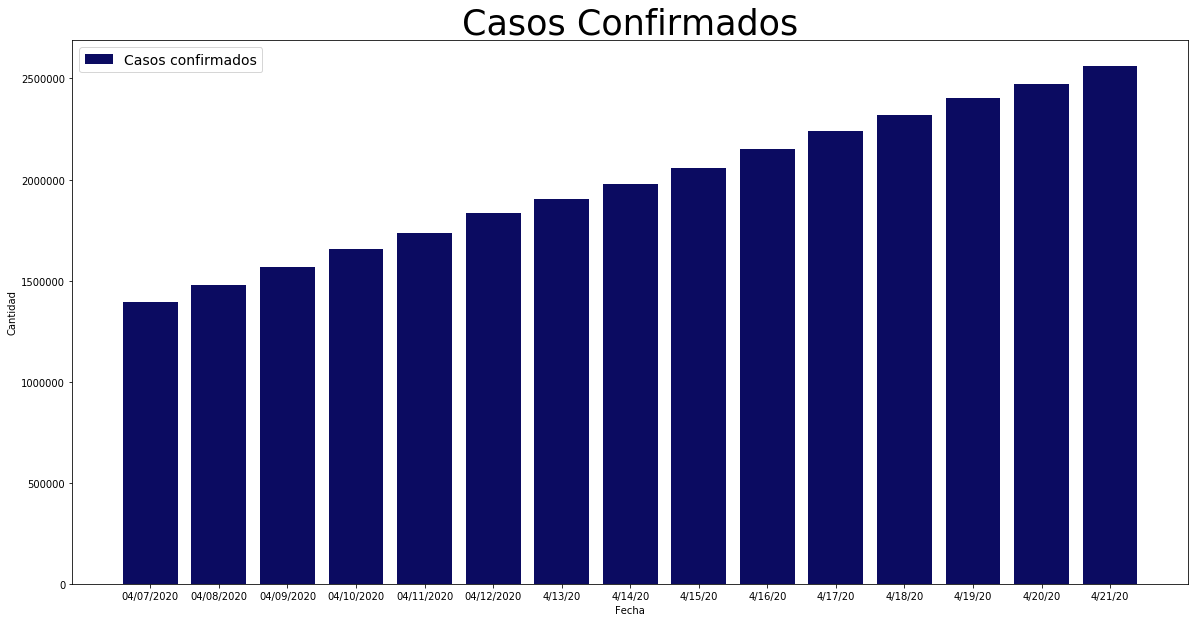

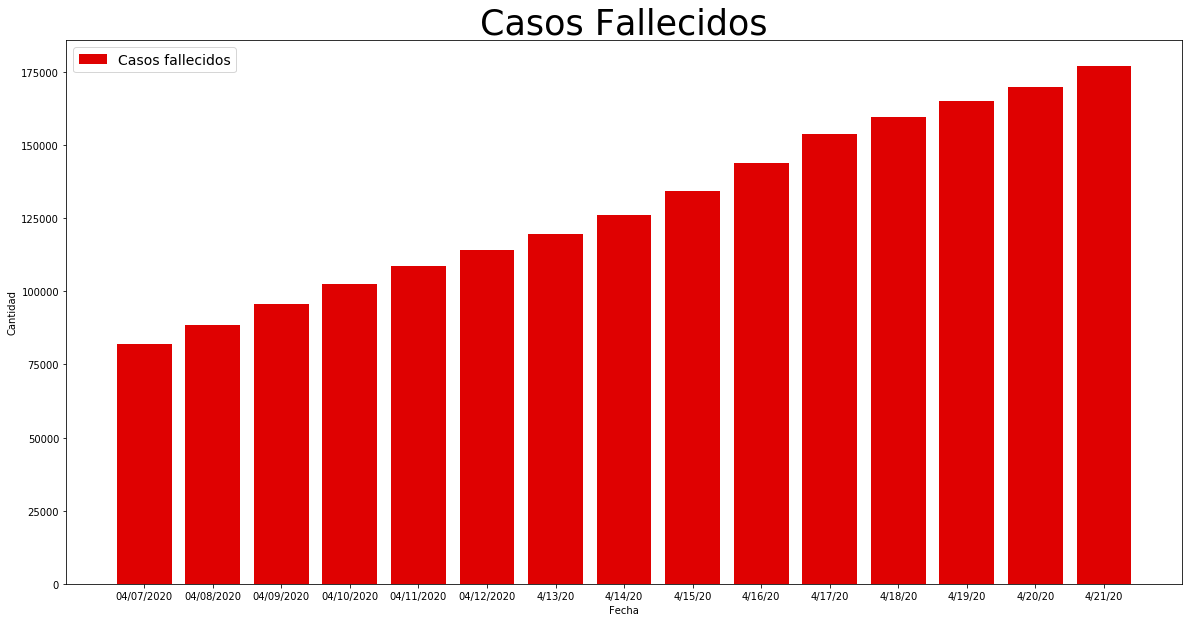

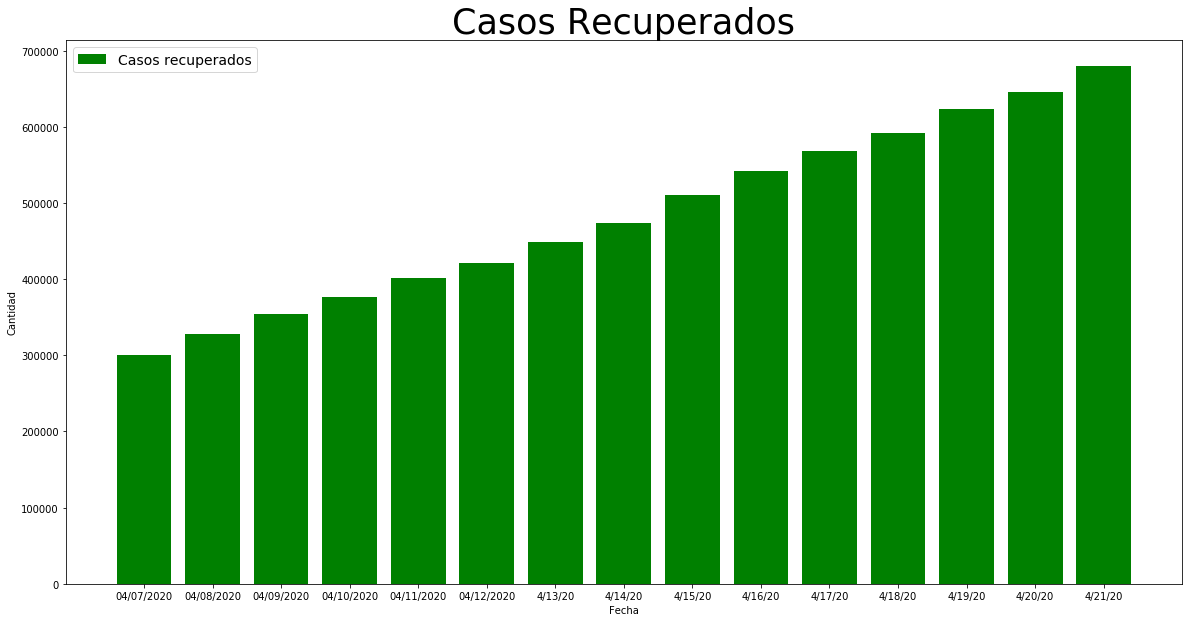

In [36]:
p = dfDateCases
p = p.tail(15)

plt.figure(figsize=(20,10))
plt.bar(p.Date, p.TotalConfirmed, label="Casos confirmados",color="#0B0B61")
plt.xlabel('Fecha')
plt.ylabel("Cantidad")
plt.legend(frameon=True, fontsize=14)
plt.title('Casos Confirmados',fontsize = 35)
plt.show()

plt.figure(figsize=(20,10))
plt.bar(p.Date, p.TotalDeaths, label="Casos fallecidos",color="#DF0101")
plt.xlabel('Fecha')
plt.ylabel("Cantidad")
plt.legend(frameon=True, fontsize=14)
plt.title('Casos Fallecidos',fontsize = 35)
plt.show()

plt.figure(figsize=(20,10))
plt.bar(p.Date, p.TotalRecovered, label="Casos recuperados",color="green")
plt.xlabel('Fecha')
plt.ylabel("Cantidad")
plt.legend(frameon=True, fontsize=14)
plt.title('Casos Recuperados',fontsize = 35)
plt.show()

Con el siguiente codigo vamos a graficar los estados contagio mundilaes acumulados de una persona atraves del tiempo.

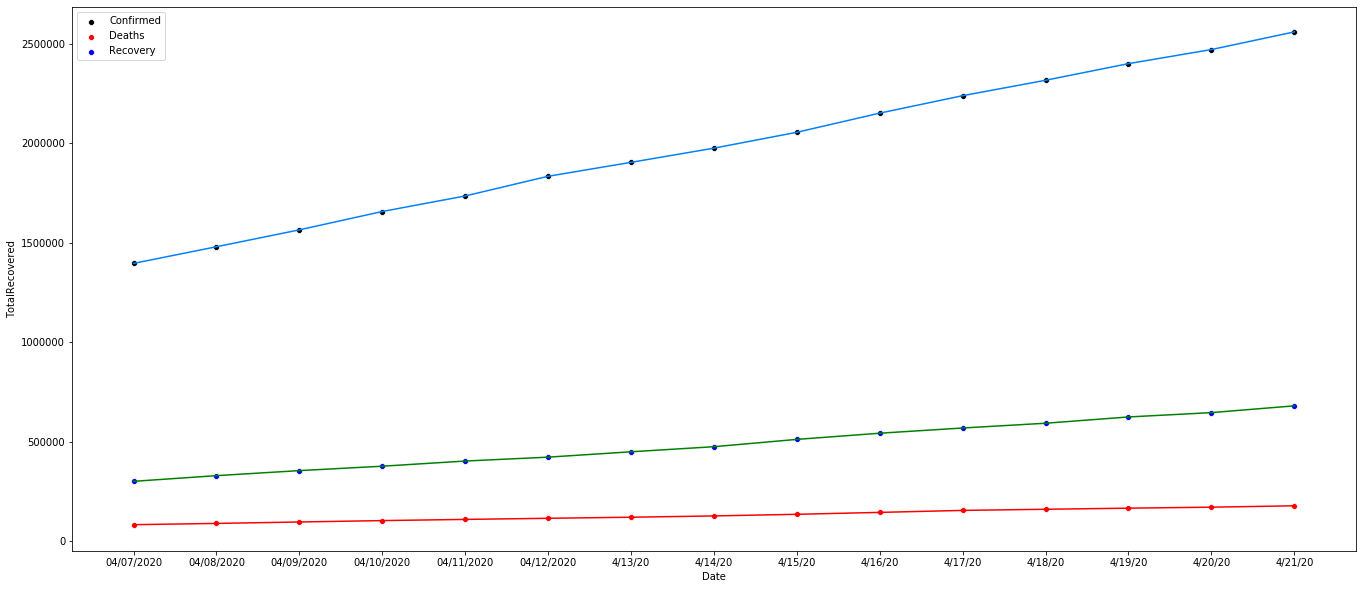

In [37]:
p = dfDateCases
p = p.tail(15)

f, ax = plt.subplots(figsize=(23,10))
ax=sns.scatterplot(x="Date", y="TotalConfirmed", data=p,
             color="black",label = "Confirmed")
ax=sns.scatterplot(x="Date", y="TotalDeaths", data=p,
             color="red",label = "Deaths")
ax=sns.scatterplot(x="Date", y="TotalRecovered", data=p,
             color="blue",label = "Recovery")
plt.plot(p.Date,p.TotalConfirmed,zorder=1,color="#0080FF")
plt.plot(p.Date,p.TotalDeaths,zorder=1,color="red")
plt.plot(p.Date,p.TotalRecovered,zorder=1,color="green")

Linea azul: casos confirmados.
Linea roja: casos fallecidos.
Linea verde: casos recuperados.

Podemos observar que en las últimas 15 fechas el total de confirmados ha ido incrementando de forma exponencial, mientras que en los casos de recuperados y fallecidos también ha ido incrementado levemente.

Se observa que desde la fecha 7 de abril el número de confirmados era menor a 1,500,000 a nivel mundial, desde esa fecha hasta el 21 de abril (último registro de nuestro dataframe) superó los 2,500,000, es decir, una gran diferencia en tan solo 15 días, aproximadamente más de 1,000,000 de casos confirmados. 

Ahora con los casos de recuperados era aproximadamente una cantidad de 250,000 de recuperados a nivel mundial en la fecha inicial 7 de abril, desde esa fecha hasta el 21 de abril (último registro de nuestro dataframe) superó  los 500,000 recuperados, aproximadamente más de 250,000 de casos recuperados, es decir, hubo un incremento del 100% aproximandamente. 

En comparación de los casos confirmados y casos recuperados, los casos de fallecidos no han tenido una variación significativa entre esas fechas.
 
Por lo tanto, se obtiene un 25% aproximadamente de indice de recuperación y un 1%aproximadamente de fallecidos entre el 7 de abril y el 21 de abril.

El siguiente código nos muestra los top 10 de los paises con más confirmados de COVID-19 a nivel mundial, entonces se puede ver la gran diferencia de casos en cada país (EU vs Russia) por lo que la situación en cada uno es muy distinta y esto puede ser por los factores que tenga cada país.

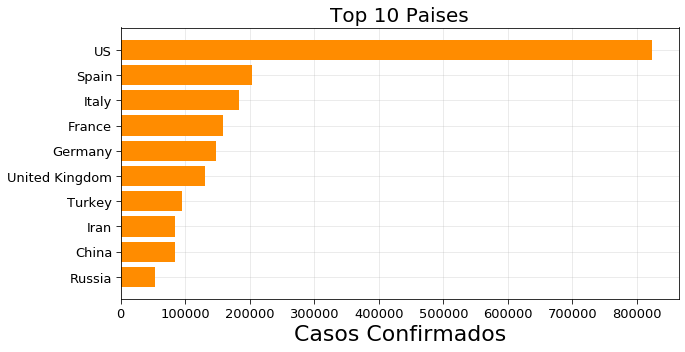

In [38]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(dfConfirmed.sort_values('Confirmed')["Confirmed"].index[-10:],dfConfirmed.sort_values('Confirmed')["Confirmed"].values[-10:],color="darkorange")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Casos Confirmados",fontsize=22)
plt.title("Top 10 Paises",fontsize=20)
plt.grid(alpha=0.3,which='both')

El siguiente código nos muestra los top 10 de los paises con más fallecidos de COVID-19 a nivel mundial, entonces se puede ver la gran diferencia de casos en cada país (EU vs Netherlands) por lo que la situación en cada uno es muy distinta y esto puede ser por los factores que tenga cada país.

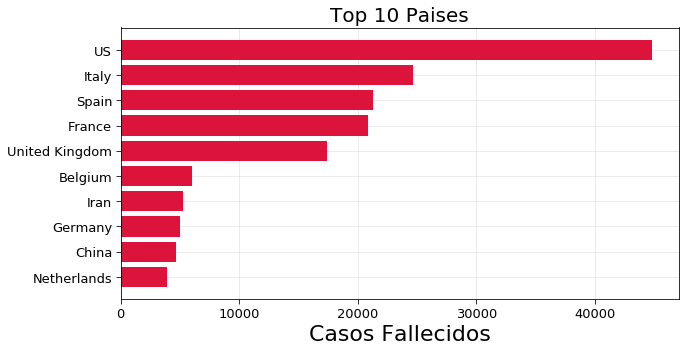

In [39]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(dfDeaths.sort_values('Deaths')["Deaths"].index[-10:],dfDeaths.sort_values('Deaths')["Deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Casos Fallecidos",fontsize=22)
plt.title("Top 10 Paises",fontsize=20)
plt.grid(alpha=0.3,which='both')

El siguiente código nos muestra los top 10 de los paises con más recuerados de COVID-19 a nivel mundial, entonces se puede ver la gran diferencia de casos en cada país (Germany vs Turkey) por lo que la situación en cada uno es muy distinta y esto puede ser por los factores que tenga cada país.

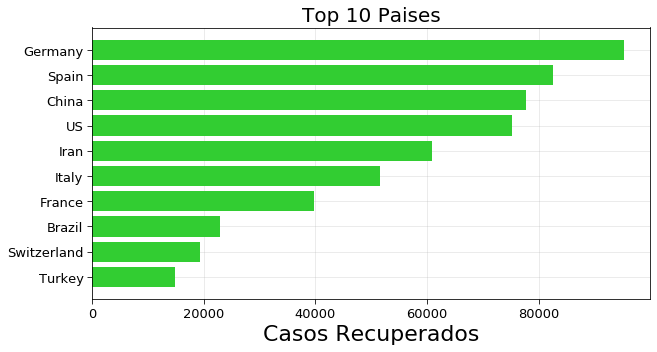

In [40]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(dfRecovered.sort_values('Recovered')["Recovered"].index[-10:],dfRecovered.sort_values('Recovered')["Recovered"].values[-10:],color="limegreen")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Casos Recuperados",fontsize=22)
plt.title("Top 10 Paises",fontsize=20)
plt.grid(alpha=0.3,which='both')

Analizando la gráfica se observa que US tiene el primer lugar en casos confirmados y casos fallecidos, pero en casos de recuperados se muestra en el cuarto lugar, por lo que podemos suponer que hay otros factores que están afectando el sistema de salud de US a diferencia de los demás países (Top 10 recuperados).

### Creación de la formula para obtener la probabilidad de un país de los estados (confirmed, deaths, recovered) posbiles de covid 19.

In [41]:
def probabilidad (total_mundial, total_regional):
    resultado = (total_regional / total_mundial)
    return resultado

In [42]:
TotalConfirmed = new_covid_confirmed['4/21/20'].sum()
print(TotalConfirmed)

2561043


Esta variable respresenta el acumulativo total de casos confirmados de covid 19 hasta la fecha a nivel mundial (01/22/2020 - 04/21/2020), se declara la variable para hacer cálculos de probabilidad más adelante.

In [43]:
TotalDeaths = new_covid_deaths['4/21/20'].sum()
print(TotalDeaths)

176983


Esta variable respresenta el acumulativo total de casos fallecidos de covid 19 hasta la fecha a nivel mundial (01/22/2020 - 04/21/2020), se declara la variable para hacer cálculos de probabilidad más adelante.

In [44]:
TotalRecovered = new_covid_recovered['4/21/20'].sum()
print(TotalRecovered)

679819


Esta variable respresenta el acumulativo total de casos recuperados de covid 19 hasta la fecha a nivel mundial (01/22/2020 - 04/21/2020), se declara la variable para hacer cálculos de probabilidad más adelante.

## Creación de las clase de interes de acumulados de los estado Confirmed, Deaths, Recovered en base a la región US respecto al tiempo inicial hasta la actual (01/22/2020 hasta el 04/21/2020).

In [45]:
clase_US_confirmed = new_covid_confirmed[covid_confirmed['Country']=='US']
clase_US_confirmed.to_csv('Clase_US_Confirmed.csv', index=False)

In [46]:
clase_US_deaths = new_covid_deaths[covid_deaths['Country']=='US']
clase_US_deaths.to_csv('Clase_US_Deaths.csv', index=False)

In [47]:
clase_US_recovered = new_covid_recovered[covid_recovered['Country']=='US']
clase_US_recovered.to_csv('Clase_US_Recovered.csv', index=False)

### Análisis de las clases clase_US perteneciente a 'Country' (país) de Estados Unidos de América

#### EN clase_US_confirmed

In [48]:
Cs_us_confirmed = pd.read_csv("Clase_US_Confirmed.csv") 
Cs_us_confirmed.head()

,State,Country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,04/12/2020,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,US,1,1,2,2,5,5,5,5,...,555313,580619,607670,636350,667592,699706,732197,759086,784326,823786


In [49]:
TotalConfirmed_us = Cs_us_confirmed['4/21/20'].sum()
print (TotalConfirmed_us)

823786


variable que representa el total de confirmados de covid 19 hasta la última fecha actual 4/21/20.

##### En la siguiente operación se obtendrá la probabilidad de casos confirmados de US a nivel mundial.

In [50]:
probabilidad_us_confirmed = probabilidad(TotalConfirmed, TotalConfirmed_us)

print("\nTotal Mundial Confirmados: ",TotalConfirmed)
print("\nTotal US Confirmados: ",TotalConfirmed_us)
print("\nProbabilidad de confirmados: ", probabilidad_us_confirmed)


Total Mundial Confirmados:  2561043

Total US Confirmados:  823786

Probabilidad de confirmados:  0.32166035478514027


#### RESPUESTA INTERÉS: Los resultados los podemos interpretar de la siguiente manera, que la probabilidad de que una persona contagiada de covid 19 sea de la región de US es de 0.32% a nivel mundial.

#### EN clase_US_deaths

In [51]:
Cs_us_deaths = pd.read_csv("Clase_US_Deaths.csv") 
Cs_us_deaths.head()

,State,Country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,04/12/2020,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,US,0,0,0,0,0,0,0,0,...,22019,23528,25831,28325,32916,36773,38664,40661,42094,44845


In [52]:
TotalDeaths_us = Cs_us_deaths['4/21/20'].sum()
print (TotalDeaths_us)

44845


variable que representa el total de fallecidos de covid 19 hasta la última fecha actual 4/21/20.

##### En la siguiente operación se obtendrá la probabilidad de casos fallecidos de US a nivel mundial.

In [53]:
probabilidad_us_deaths = probabilidad(TotalDeaths, TotalDeaths_us)

print("Total Mundial Fallecidos: ",TotalDeaths)
print("\nTotal US Fallecidos: ",TotalDeaths_us)
print("\nProbabilidad de Fallecidos: ", probabilidad_us_deaths)

Total Mundial Fallecidos:  176983

Total US Fallecidos:  44845

Probabilidad de Fallecidos:  0.2533859184215433


#### RESPUESTA INTERÉS: Los resultados los podemos interpretar de la siguiente manera, que la probabilidad de que una persona haya fallecido de covid 19 sea de la región de US es de 0.25% a nivel mundial.

#### EN clase_US_recovered

In [54]:
Cs_us_recovered = pd.read_csv("Clase_US_Recovered.csv") 
Cs_us_recovered.head()

,State,Country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,04/12/2020,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,US,0,0,0,0,0,0,0,0,...,32988,43482,47763,52096,54703,58545,64840,70337,72329,75204


In [55]:
TotalRecovered_us = Cs_us_recovered['4/21/20'].sum()
print (TotalRecovered_us)

75204


variable que representa el total de recuperados de covid 19 hasta la última fecha actual 4/21/20.

##### En la siguiente operación se obtendrá la probabilidad de casos recuperados de US a nivel mundial.

In [56]:
probabilidad_us_recovered = probabilidad(TotalRecovered, TotalRecovered_us)

print("Total Mundial Recuperados: ",TotalRecovered)
print("\nTotal US Recuperados: ",TotalRecovered_us)
print("\nProbabilidad de Recuperados: ", probabilidad_us_recovered)

Total Mundial Recuperados:  679819

Total US Recuperados:  75204

Probabilidad de Recuperados:  0.1106235630366318


#### RESPUESTA INTERÉS: Los resultados los podemos interpretar de la siguiente manera, que la probabilidad de que una persona haya sido recuperada de covid 19 sea de la región de US es de 0.11% a nivel mundial.

## Prediccion de los datos

#### Prediccón mundial de casos confirmados de COVID-19

A continuación, haremos una predicción sobre el número de contagios, recuperados y muertes por COVID-19 a nivel mundial. Nuestra base de datos cuenta con información hasta el 21 de Mayo de 2020. Por lo tanto buscaremos pronosticar la cantidad de cada uno de los estados de COVID-19  a nivel mundial en el futuro.


Crearemos un dataframe llamado pred_cnfrm, el cual almacenara datos de tipo fecha y los datos acumulados mundiales de casos confirmados del dataframe dfDateCases anteriormente creado.

In [57]:
pred_cnfrm = dfDateCases.loc[:,["Date","TotalConfirmed"]]
pred_cnfrm

,Date,TotalConfirmed
0,1/22/20,555
1,1/23/20,654
2,1/24/20,941
3,1/25/20,1434
4,1/26/20,2118
...,...,...
86,4/17/20,2240190
87,4/18/20,2317758
88,4/19/20,2401378
89,4/20/20,2472258


A continuación se crea otro dataframe llamado pr_data que nos servirá para almacenar la tendencia que resulta de la función Prophet().

In [79]:
pr_data = pred_cnfrm.tail(10) #Número de fechas historicas que se desea utilizar.
pr_data.columns = ['ds','y']  #La entrada a Prophet siempre es un marco de datos con dos columnas: ds y y. 
#La ds columna (marca de fecha) debe tener el formato esperado por Pandas, idealmente AAAA-MM-DD para una fecha o AAAA-MM-DD HH: MM: SS para una marca de tiempo. 
#La y columna debe ser numérica y representa la medida que deseamos pronosticar.
m=Prophet() #Ajustamos el modelo creando instancias de un nuevo Prophetobjeto. Cualquier configuración del procedimiento de pronóstico se pasa al constructor. 
m.fit(pr_data) #Luego llama a su fitmétodo y pasa el marco de datos histórico.
future=m.make_future_dataframe(periods=22) #Luego se hacen predicciones en un marco de datos con una columna que dscontiene las fechas para las cuales se debe hacer una predicción. 
#Puede obtener un marco de datos adecuado que se extienda en el futuro un número específico de días utilizando.
#Por defecto también incluirá las fechas del historial, por lo que también veremos el ajuste del modelo.
forecast=m.predict(future) #El predictmétodo asignará cada fila en futureun valor predicho que nombre yhat. 
#Si pasa fechas históricas, proporcionará un ajuste en la muestra. 
#El forecastobjeto aquí es un nuevo marco de datos que incluye una columna yhatcon el pronóstico, así como columnas para componentes e intervalos de incertidumbre.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


A continuación se creara un dataframe llamado cnfrm para almacenar la predicción obtenida en el forcecast que incluirá solamente nuestros datos de interés "ds" que son las fechas y "trend" que son las predicciones o tendencias.

In [80]:
cnfrm = forecast.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm.columns = ['Date','Confirm']
#cnfrm.head(10)

Para poder ver los componentes del pronóstico, usaremos plot_plotly.

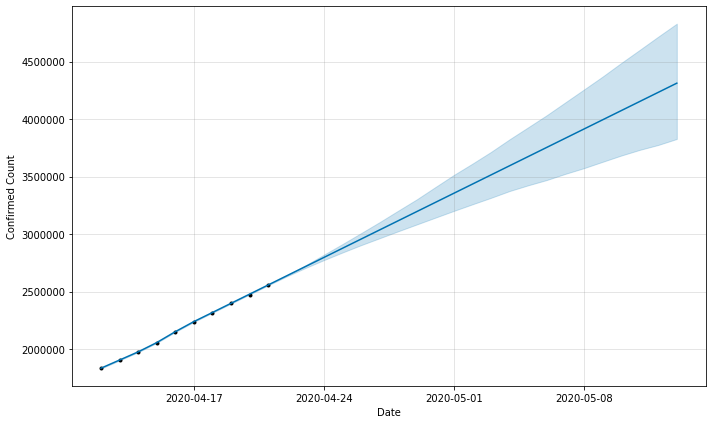

In [81]:
fig = plot_plotly(m, forecast)
py.iplot(fig) 
fig = m.plot(forecast,xlabel='Date',ylabel='Confirmed Count')

La grafica nos muestra una predicción de los casos confirmados mundialmente de 22 días a partir de (21/04/2020) última fecha de registro de nuestra base de datos al (13/05/2020) fecha actual. Sabemos que el total de casos confirmados a nivel mundial al 21/04/2020 es de 2,561,043 de personas contagiadas por COVID-19 y nuestra predicción indica que al 13/05/2020 ascenderán aproximadamente a los 4,312,430 de personas contagiadas por COVID-19.

#### Prediccón mundial de casos recuperados de COVID-19

Crearemos un dataframe llamado pred_recup, el cual almacenara datos de tipo fecha y los datos acumulados mundiales de casos recuperados del dataframe dfDateCases anteriormente creado.

In [61]:
pred_recup = dfDateCases.loc[:,["Date","TotalRecovered"]]
pred_recup

,Date,TotalRecovered
0,1/22/20,28
1,1/23/20,30
2,1/24/20,36
3,1/25/20,39
4,1/26/20,52
...,...,...
86,4/17/20,568343
87,4/18/20,592319
88,4/19/20,623903
89,4/20/20,645738


A continuación se crea otro dataframe llamado pr_data_recup que nos servirá para almacenar la tendencia que resulta de la función Prophet().

In [62]:
pr_data_recup = pred_recup.tail(10) #Número de fechas historicas que se desea utilizar.
pr_data_recup.columns = ['ds','y']  #La entrada a Prophet siempre es un marco de datos con dos columnas: ds y y. 
#La ds columna (marca de fecha) debe tener el formato esperado por Pandas, idealmente AAAA-MM-DD para una fecha o AAAA-MM-DD HH: MM: SS para una marca de tiempo. 
#La y columna debe ser numérica y representa la medida que deseamos pronosticar.
m=Prophet() #Ajustamos el modelo creando instancias de un nuevo Prophetobjeto. Cualquier configuración del procedimiento de pronóstico se pasa al constructor. 
m.fit(pr_data_recup) #Luego llama a su fitmétodo y pasa el marco de datos histórico.
future=m.make_future_dataframe(periods=22) #Luego se hacen predicciones en un marco de datos con una columna que dscontiene las fechas para las cuales se debe hacer una predicción. 
#Puede obtener un marco de datos adecuado que se extienda en el futuro un número específico de días utilizando.
#Por defecto también incluirá las fechas del historial, por lo que también veremos el ajuste del modelo.
forecast=m.predict(future) #El predictmétodo asignará cada fila en futureun valor predicho que nombre yhat. 
#Si pasa fechas históricas, proporcionará un ajuste en la muestra. 
#El forecastobjeto aquí es un nuevo marco de datos que incluye una columna yhatcon el pronóstico, así como columnas para componentes e intervalos de incertidumbre.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


A continuación se creara un dataframe llamado recup para almacenar la predicción obtenida en el forcecast que incluirá solamente nuestros datos de interés "ds" que son las fechas y "trend" que son las predicciones o tendencias.

In [63]:
recup = forecast.loc[:,['ds','trend']]
recup = recup[recup['trend']>0]
recup.columns = ['Date','Recovered']
#recup.head(10)

Para poder ver los componentes del pronóstico, usaremos plot_plotly

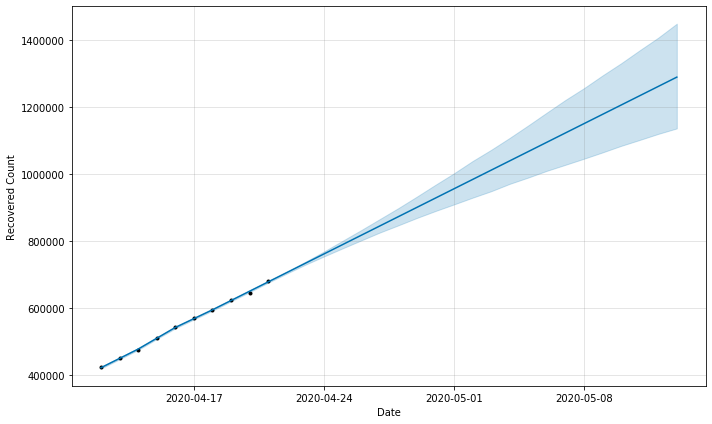

In [64]:
fig = plot_plotly(m, forecast)
py.iplot(fig) 
fig = m.plot(forecast,xlabel='Date',ylabel='Recovered Count')

La grafica nos muestra una predicción de los casos recuperados mundialmente de 22 días a partir de (21/04/2020) última fecha de registro de nuestra base de datos al (13/05/2020) fecha actual. Sabemos que el total de casos recuperados a nivel mundial al 21/04/2020 es de 679,819 de personas recuperadas de COVID-19 y nuestra predicción indica que al 13/05/2020 ascenderán aproximadamente a los 1,289,403 de personas recuperadas de COVID-19.

#### Prediccón mundial de casos de defunción de COVID-19

Crearemos un dataframe llamado pred_deaths, el cual almacenara datos de tipo fecha y los datos acumulados mundiales de casos de defunción del dataframe dfDateCases anteriormente creado.

In [65]:
pred_deaths = dfDateCases.loc[:,["Date","TotalDeaths"]]
pred_deaths

,Date,TotalDeaths
0,1/22/20,17
1,1/23/20,18
2,1/24/20,26
3,1/25/20,42
4,1/26/20,56
...,...,...
86,4/17/20,153821
87,4/18/20,159509
88,4/19/20,165043
89,4/20/20,169985


A continuación se crea otro dataframe llamado pr_data_deaths que nos servirá para almacenar la tendencia que resulta de la función Prophet().

In [66]:
pr_data_deaths = pred_deaths.tail(10) #Número de fechas historicas que se desea utilizar.
pr_data_deaths.columns = ['ds','y']  #La entrada a Prophet siempre es un marco de datos con dos columnas: ds y y. 
#La ds columna (marca de fecha) debe tener el formato esperado por Pandas, idealmente AAAA-MM-DD para una fecha o AAAA-MM-DD HH: MM: SS para una marca de tiempo. 
#La y columna debe ser numérica y representa la medida que deseamos pronosticar.
m=Prophet() #Ajustamos el modelo creando instancias de un nuevo Prophetobjeto. Cualquier configuración del procedimiento de pronóstico se pasa al constructor. 
m.fit(pr_data_deaths) #Luego llama a su fitmétodo y pasa el marco de datos histórico.
future=m.make_future_dataframe(periods=22) #Luego se hacen predicciones en un marco de datos con una columna que dscontiene las fechas para las cuales se debe hacer una predicción. 
#Puede obtener un marco de datos adecuado que se extienda en el futuro un número específico de días utilizando.
#Por defecto también incluirá las fechas del historial, por lo que también veremos el ajuste del modelo.
forecast=m.predict(future) #El predictmétodo asignará cada fila en futureun valor predicho que nombre yhat. 
#Si pasa fechas históricas, proporcionará un ajuste en la muestra. 
#El forecastobjeto aquí es un nuevo marco de datos que incluye una columna yhatcon el pronóstico, así como columnas para componentes e intervalos de incertidumbre.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


A continuación se creara un dataframe llamado deaths para almacenar la predicción obtenida en el forcecast que incluirá solamente nuestros datos de interés "ds" que son las fechas y "trend" que son las predicciones o tendencias

In [67]:
deaths = forecast.loc[:,['ds','trend']]
deaths = deaths[deaths['trend']>0]
deaths.columns = ['Date','Deaths']
#recup.head(10)

Para poder ver los componentes del pronóstico, usaremos plot_plotly

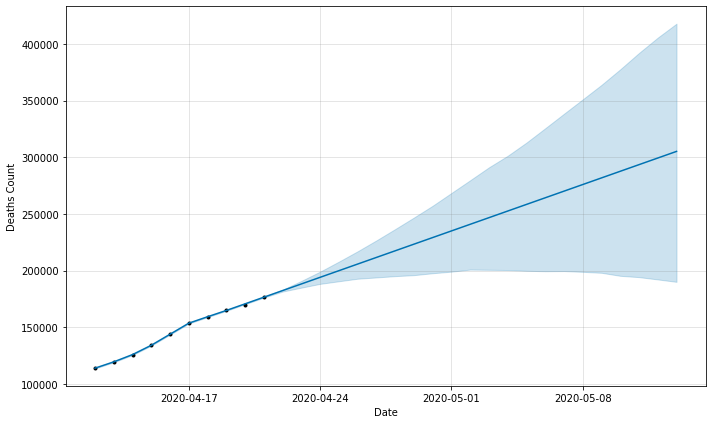

In [68]:
fig = plot_plotly(m, forecast)
py.iplot(fig) 
fig = m.plot(forecast,xlabel='Date',ylabel='Deaths Count')

La grafica nos muestra una predicción de los casos de defunción mundialmente de 22 días a partir de (21/04/2020) última fecha de registro de nuestra base de datos al (13/05/2020) fecha actual. Sabemos que el total de casos de defunción a nivel mundial al 21/04/2020 es de 176,983 de personas fallecidas por COVID-19 y nuestra predicción indica que al 13/05/2020 ascenderán aproximadamente a los 305,727 de personas fallecidas por COVID-19

A continuación, haremos una predicción sobre el número de contagios, recuperados y muertes por COVID-19 en la region de los Estados Unidos. Nuestra base de datos cuenta con información hasta el 21 de Mayo de 2020. Por lo tanto buscaremos pronosticar la cantidad de cada uno de los estados de COVID-19 para los Estados Unidos en el futuro.

#### Prediccón de casos confirmados de COVID-19 en los Estados Unidos

Crearemos un dataframe llamado pred_cnfrm_us, el cual almacenara datos de tipo fecha y los datos acumulados nacionales de casos confirmados en los Estados Unidos del dataframe dfus anteriormente creado.

In [84]:
pred_cnfrm_us = dfus.loc[:,["Date","Confirmed"]]
pred_cnfrm_us

,Date,Confirmed
0,1/22/20,1
1,1/23/20,1
2,1/24/20,2
3,1/25/20,2
4,1/26/20,5
...,...,...
86,4/17/20,699706
87,4/18/20,732197
88,4/19/20,759086
89,4/20/20,784326


A continuación se crea otro dataframe llamado pr_data_us que nos servirá para almacenar la tendencia que resulta de la función Prophet().

In [85]:
pr_data_us = pred_cnfrm_us.tail(10) #Número de fechas historicas que se desea utilizar.
pr_data_us.columns = ['ds','y']  #La entrada a Prophet siempre es un marco de datos con dos columnas: ds y y. 
#La ds columna (marca de fecha) debe tener el formato esperado por Pandas, idealmente AAAA-MM-DD para una fecha o AAAA-MM-DD HH: MM: SS para una marca de tiempo. 
#La y columna debe ser numérica y representa la medida que deseamos pronosticar.
m=Prophet() #Ajustamos el modelo creando instancias de un nuevo Prophetobjeto. Cualquier configuración del procedimiento de pronóstico se pasa al constructor. 
m.fit(pr_data_us) #Luego llama a su fitmétodo y pasa el marco de datos histórico.
future=m.make_future_dataframe(periods=22) #Luego se hacen predicciones en un marco de datos con una columna que dscontiene las fechas para las cuales se debe hacer una predicción. 
#Puede obtener un marco de datos adecuado que se extienda en el futuro un número específico de días utilizando.
#Por defecto también incluirá las fechas del historial, por lo que también veremos el ajuste del modelo.
forecast=m.predict(future) #El predictmétodo asignará cada fila en futureun valor predicho que nombre yhat. 
#Si pasa fechas históricas, proporcionará un ajuste en la muestra. 
#El forecastobjeto aquí es un nuevo marco de datos que incluye una columna yhatcon el pronóstico, así como columnas para componentes e intervalos de incertidumbre.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


A continuación se creara un dataframe llamado cnfrm_us para almacenar la predicción obtenida en el forcecast que incluirá solamente nuestros datos de interés "ds" que son las fechas y "trend" que son las predicciones o tendencias.

In [105]:
cnfrm_us = forecast.loc[:,['ds','trend']]
cnfrm_us = cnfrm_us[cnfrm_us['trend']>0]
cnfrm_us.columns = ['Date','Confirm']
#cnfrm_us.head(10)

Para poder ver los componentes del pronóstico, usaremos plot_plotly.

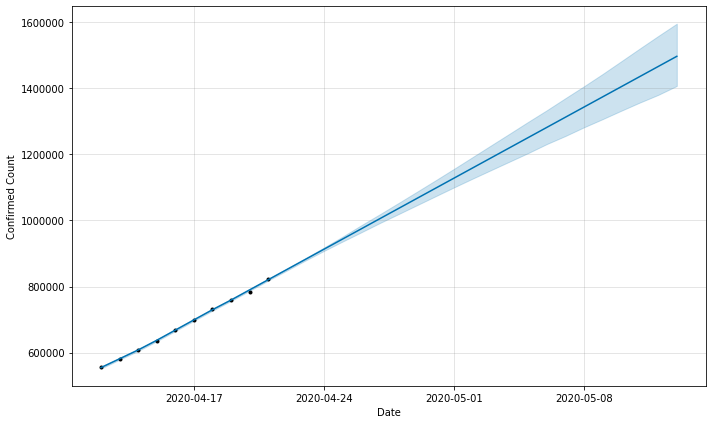

In [87]:
fig = plot_plotly(m, forecast)
py.iplot(fig) 
fig = m.plot(forecast,xlabel='Date',ylabel='Confirmed Count')

La grafica nos muestra una predicción de los casos confirmados en los Estados Unidos de 22 días a partir de (21/04/2020) última fecha de registro de nuestra base de datos al (13/05/2020) fecha actual. Sabemos que el total de casos confirmados en los Estados Unidos al 21/04/2020 es de 823,786 de personas contagiadas por COVID-19 y nuestra predicción indica que al 13/05/2020 ascenderán aproximadamente a los 1,497,081 de personas contagiadas por COVID-19 en los Estados Unidos.

#### Prediccón de casos recuperados de COVID-19 en los Estados Unidos

Crearemos un dataframe llamado pred_recup_us, el cual almacenara datos de tipo fecha y los datos acumulados de casos recuperados de COVID-19 en los Estados Unidos del dataframe dfus anteriormente creado.

In [108]:
pred_recup_us = dfus.loc[:,["Date","Recovered"]]
pred_recup_us

,Date,Recovered
0,1/22/20,0
1,1/23/20,0
2,1/24/20,0
3,1/25/20,0
4,1/26/20,0
...,...,...
86,4/17/20,58545
87,4/18/20,64840
88,4/19/20,70337
89,4/20/20,72329


A continuación se crea otro dataframe llamado pr_data_recup_us que nos servirá para almacenar la tendencia que resulta de la función Prophet().

In [109]:
pr_data_recup_us = pred_recup_us.tail(10) #Número de fechas historicas que se desea utilizar.
pr_data_recup_us.columns = ['ds','y']  #La entrada a Prophet siempre es un marco de datos con dos columnas: ds y y. 
#La ds columna (marca de fecha) debe tener el formato esperado por Pandas, idealmente AAAA-MM-DD para una fecha o AAAA-MM-DD HH: MM: SS para una marca de tiempo. 
#La y columna debe ser numérica y representa la medida que deseamos pronosticar.
m=Prophet() #Ajustamos el modelo creando instancias de un nuevo Prophetobjeto. Cualquier configuración del procedimiento de pronóstico se pasa al constructor. 
m.fit(pr_data_recup_us) #Luego llama a su fitmétodo y pasa el marco de datos histórico.
future=m.make_future_dataframe(periods=22) #Luego se hacen predicciones en un marco de datos con una columna que dscontiene las fechas para las cuales se debe hacer una predicción. 
#Puede obtener un marco de datos adecuado que se extienda en el futuro un número específico de días utilizando.
#Por defecto también incluirá las fechas del historial, por lo que también veremos el ajuste del modelo.
forecast=m.predict(future) #El predictmétodo asignará cada fila en futureun valor predicho que nombre yhat. 
#Si pasa fechas históricas, proporcionará un ajuste en la muestra. 
#El forecastobjeto aquí es un nuevo marco de datos que incluye una columna yhatcon el pronóstico, así como columnas para componentes e intervalos de incertidumbre.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


A continuación se creara un dataframe llamado recup_us para almacenar la predicción obtenida en el forcecast que incluirá solamente nuestros datos de interés "ds" que son las fechas y "trend" que son las predicciones o tendencias.

In [110]:
recup_us = forecast.loc[:,['ds','trend']]
recup_us = recup_us[recup_us['trend']>0]
recup_us.columns = ['Date','Recovered']
#recup_us.head(10)

Para poder ver los componentes del pronóstico, usaremos plot_plotly

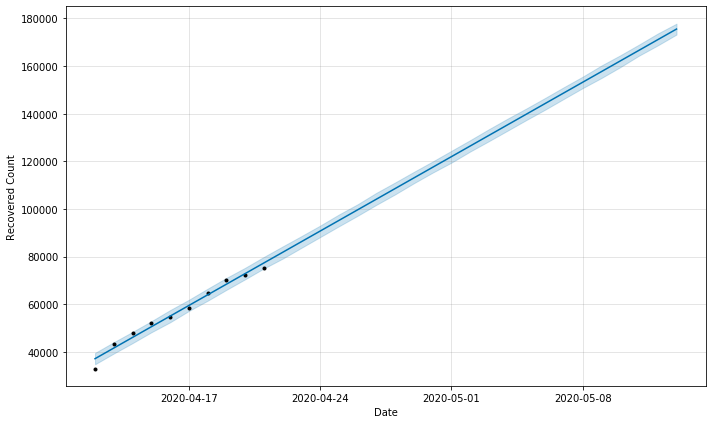

In [111]:
fig = plot_plotly(m, forecast)
py.iplot(fig) 
fig = m.plot(forecast,xlabel='Date',ylabel='Recovered Count')

La grafica nos muestra una predicción de los casos recuperados en los Estados Unidos de 22 días a partir de (21/04/2020) última fecha de registro de nuestra base de datos al (13/05/2020) fecha actual. Sabemos que el total de casos recuperados en los Estados Unidos al 21/04/2020 es de 75,204 de personas recuperadas de COVID-19 y nuestra predicción indica que al 13/05/2020 ascenderán aproximadamente a los 175,557de personas recuperadas de COVID-19 en los Estados Unidos.

Estados Unidos oficialmente al (13/05/2020) tiene 253,000 casos recuperados y nuestra predicción nos dice que debieron haber llegado a los 175,557 casos recuperados el (13/05/2020), por lo que podemos decir que los Estados Unidos han logrado aumentar el índice de recuperación que tenía a partir del primer día que se empezó la predicción, es decir, el (21/Abril/2020).

#### Prediccón mundial de casos de defunción de COVID-19 en los Estados Unidos

Crearemos un dataframe llamado pred_deaths_us, el cual almacenara datos de tipo fecha y los datos acumulados de casos de defunción en los Estados Unidos del dataframe dfus anteriormente creado.

In [112]:
pred_deaths_us = dfus.loc[:,["Date","Deaths"]]
pred_deaths_us

,Date,Deaths
0,1/22/20,0
1,1/23/20,0
2,1/24/20,0
3,1/25/20,0
4,1/26/20,0
...,...,...
86,4/17/20,36773
87,4/18/20,38664
88,4/19/20,40661
89,4/20/20,42094


A continuación se crea otro dataframe llamado pr_data_deaths_us que nos servirá para almacenar la tendencia que resulta de la función Prophet().

In [117]:
pr_data_deaths_us = pred_deaths_us.tail(10) #Número de fechas historicas que se desea utilizar.
pr_data_deaths_us.columns = ['ds','y']  #La entrada a Prophet siempre es un marco de datos con dos columnas: ds y y. 
#La ds columna (marca de fecha) debe tener el formato esperado por Pandas, idealmente AAAA-MM-DD para una fecha o AAAA-MM-DD HH: MM: SS para una marca de tiempo. 
#La y columna debe ser numérica y representa la medida que deseamos pronosticar.
m=Prophet() #Ajustamos el modelo creando instancias de un nuevo Prophetobjeto. Cualquier configuración del procedimiento de pronóstico se pasa al constructor. 
m.fit(pr_data_deaths_us) #Luego llama a su fitmétodo y pasa el marco de datos histórico.
future=m.make_future_dataframe(periods=22) #Luego se hacen predicciones en un marco de datos con una columna que dscontiene las fechas para las cuales se debe hacer una predicción. 
#Puede obtener un marco de datos adecuado que se extienda en el futuro un número específico de días utilizando.
#Por defecto también incluirá las fechas del historial, por lo que también veremos el ajuste del modelo.
forecast=m.predict(future) #El predictmétodo asignará cada fila en futureun valor predicho que nombre yhat. 
#Si pasa fechas históricas, proporcionará un ajuste en la muestra. 
#El forecastobjeto aquí es un nuevo marco de datos que incluye una columna yhatcon el pronóstico, así como columnas para componentes e intervalos de incertidumbre.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


A continuación se creara un dataframe llamado deaths_us para almacenar la predicción obtenida en el forcecast que incluirá solamente nuestros datos de interés "ds" que son las fechas y "trend" que son las predicciones o tendencias

In [118]:
deaths_us = forecast.loc[:,['ds','trend']]
deaths_us = deaths_us[deaths_us['trend']>0]
deaths_us.columns = ['Date','Deaths']
#recup_us.head(10)

Para poder ver los componentes del pronóstico, usaremos plot_plotly

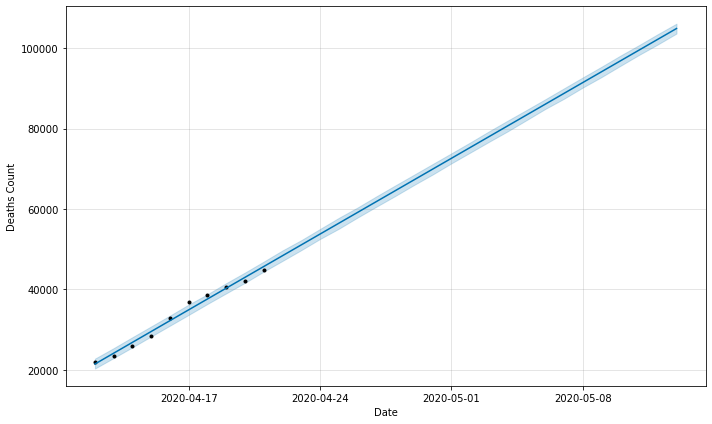

In [119]:
fig = plot_plotly(m, forecast)
py.iplot(fig) 
fig = m.plot(forecast,xlabel='Date',ylabel='Deaths Count')

La grafica nos muestra una predicción de los casos de defunción en los Estados Unidos de 22 días a partir de (21/04/2020) última fecha de registro de nuestra base de datos al (13/05/2020) fecha actual. Sabemos que el total de casos de defunción en los Estados Unidos al 21/04/2020 es de 44,845 de personas fallecidas por COVID-19 y nuestra predicción indica que al 13/05/2020 ascenderán aproximadamente a los 104,872 de personas fallecidas por COVID-19

Estados Unidos oficialmente al (13/05/2020) tiene 86,541 casos de defunción y nuestra predicción nos dice que debieron haber llegado a los 86,000 casos de defunción el (06/05/2020), por lo que podemos decir que los Estados Unidos han logrado disminuir el índice de defunción que tenía a partir del primer día que se empezó la predicción, es decir, el (21/Abril/2020).

## Conclusión

	
1.Cambios en el número de casos afectados a lo largo del tiempo
	
2.Cambio de casos a lo largo del tiempo a nivel de país	

3.Último número de casos afectados

https://www.kaggle.com/vanshjatana/analysis-on-coronavirus kernel de predicción